In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os
import glob
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class FaceMaskDataset(Dataset):
    def __init__(self, root_dir, transform=None, classes=["with_mask", "without_mask"]):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.images = []

        for label_idx, label_name in enumerate(classes):
            label_dir = os.path.join(root_dir, label_name)
            for fname in os.listdir(label_dir):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.images.append((os.path.join(label_dir, fname), label_idx))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [3]:
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

dataset = FaceMaskDataset(root_dir="/kaggle/input/face-mask-detection/Dataset", transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 kelas: with_mask, without_mask
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Info parameter
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params / 1e6:.2f}M")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.4MB/s]


Total parameters: 11.18M
Trainable parameters: 11.18M


In [5]:
# Training loop
num_epoch = 10
train_losses = []
test_losses = []

for epoch in range(num_epoch):
    model.train()
    train_loss = 0

    for data, labels in tqdm(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)

    model.eval()
    correct = 0
    total = 0
    test_loss = 0

    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_test_loss = test_loss / len(test_loader.dataset)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss {avg_train_loss:.4f}, Test Loss {avg_test_loss:.4f}, Test Acc {acc:.4f}")

100%|██████████| 38/38 [00:14<00:00,  2.69it/s]


Epoch 1: Train Loss 0.0595, Test Loss 0.0102, Test Acc 0.9975


100%|██████████| 38/38 [00:03<00:00,  9.63it/s]


Epoch 2: Train Loss 0.0093, Test Loss 0.0150, Test Acc 0.9942


100%|██████████| 38/38 [00:03<00:00, 10.13it/s]


Epoch 3: Train Loss 0.0027, Test Loss 0.0027, Test Acc 0.9992


100%|██████████| 38/38 [00:03<00:00, 10.49it/s]


Epoch 4: Train Loss 0.0074, Test Loss 0.0067, Test Acc 0.9983


100%|██████████| 38/38 [00:04<00:00,  8.76it/s]


Epoch 5: Train Loss 0.0046, Test Loss 0.0054, Test Acc 0.9983


100%|██████████| 38/38 [00:03<00:00, 10.27it/s]


Epoch 6: Train Loss 0.0013, Test Loss 0.0058, Test Acc 0.9975


100%|██████████| 38/38 [00:03<00:00, 10.15it/s]


Epoch 7: Train Loss 0.0069, Test Loss 0.0109, Test Acc 0.9967


100%|██████████| 38/38 [00:03<00:00, 10.04it/s]


Epoch 8: Train Loss 0.0010, Test Loss 0.0014, Test Acc 0.9992


100%|██████████| 38/38 [00:03<00:00, 10.37it/s]


Epoch 9: Train Loss 0.0004, Test Loss 0.0011, Test Acc 0.9992


100%|██████████| 38/38 [00:03<00:00,  9.56it/s]

Epoch 10: Train Loss 0.0003, Test Loss 0.0009, Test Acc 0.9992


In [6]:
torch.save({
    'epoch': num_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses,
    'test_loss': test_losses,
}, 'face_mask_checkpoint.pth')


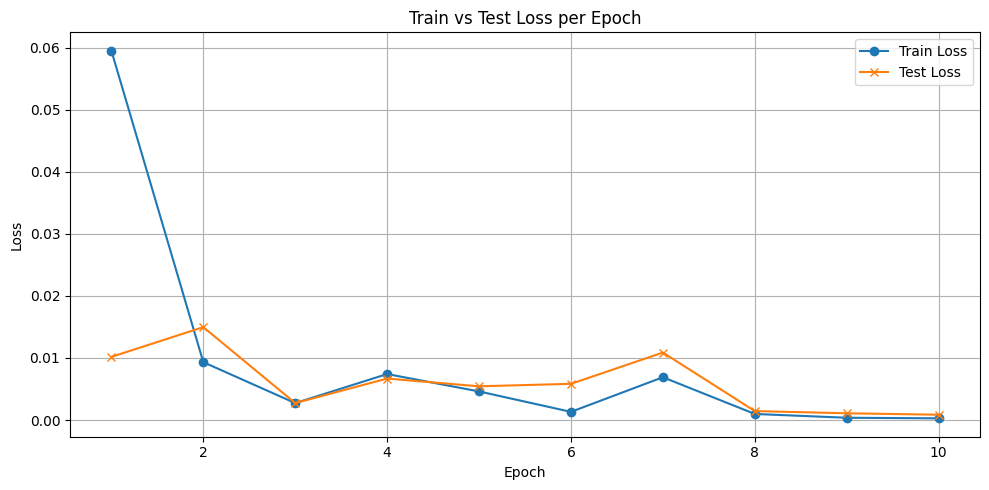

In [7]:
# Visualisasi loss
epochs = range(1, num_epoch + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Prediction: with_mask


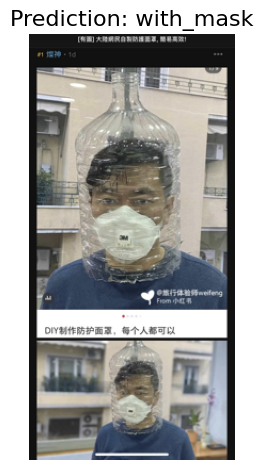

In [11]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import matplotlib.pyplot as plt

def load_model(weight_path, num_classes, device):
    checkpoint = torch.load(weight_path, map_location=device)

    model = resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, device, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, pred = torch.max(outputs, 1)

    predicted_class = class_names[pred.item()]
    return predicted_class, image

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Label yang sesuai dengan dataset FaceMaskDataset
    class_names = ['with_mask', 'without_mask']

    # Load model yang sudah dilatih
    model = load_model('face_mask_checkpoint.pth', num_classes=len(class_names), device=device)

    # Ganti path gambar sesuai kebutuhan
    img_path = '/kaggle/input/d/andrewmvd/face-mask-detection/images/maksssksksss15.png'  # contoh path gambar
    predicted_label, image = predict_image(img_path, model, device, class_names)

    print(f"Prediction: {predicted_label}")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)
    plt.tight_layout()
    plt.show()
